In [5]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.NerveNet import NerveNET, BinaryOut
from data_utils_NerveNet import SegmentationData
from solver_NerveNet import Solver
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define and Divide Dataset
The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [6]:
img_files = 'image_files.txt' 
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 1278, 'num_val': 425, 'num_test': 425} 2128
True


### Initialize Transformations, Train and Validation Dataloader
**New in dataloader**: 
1. New flag for dataloader **binary_out**. If True, it will return a binary value that is if a nerve mask is contained in the target or not. Calling e.g. train_data[0] will return inputs and targets, where targets is now a dictionary with keys **'main'** and **'binary'**, if binary_out is True.
2. New flag for dataloader **mask_only**. If True, the dataloader will return only images that contain a mask. Default is False.
3. The text file that contains the image id's can now be in the git project directory.

In [7]:
input_dim = (1, 128, 128)

binary_out = True 

mask_only = True

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'debug', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

val_data = SegmentationData(img_files,  transform = val_transforms, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

#### Plot Image

1_119.tif


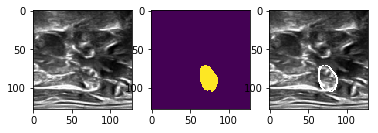

In [8]:
train_data.show_image(2)

### Initialize, Load and Manipulate Classifier

**New in classifier**: 
1. NerveNet has a new **binary_out** flag, too. If True, the forward pass will calculate a binary output. Similarly the output of the forward pass is a dictionary with keys 'main' and 'binary'.
2. The argument **upsample_unit** is a switch between simple upsampling with bilinear interpolation and transposed convolutional layers. Must be either **'Upsample'** or **'ConvTranspose2d'**. Default is 'Upsample'.
3. **Xavier Normal Initialization** is automatically applied to all NerveNet layers if initialized for the first time.

In [8]:
#model = NerveNET(input_dim, weight_scale = 0.01, dropout = 0.05, 
                #binary_out = binary_out, upsample_unit='Upsample')
model = torch.load("models/NerveNet_binary.model", map_location=lambda storage, loc: storage)

/usr/lib64/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'classifiers.NerveNet.NerveNET' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [8]:
#model.binary = BinaryOut(4, 4, activation_out= torch.nn.Softmax(), num_classes=2, weight_scale=True)

In [10]:
#Switch between main and binary classification by freezing weights
for param in list(model.parameters()): #True/False for all layers
    param.requires_grad = True

for param in list(model.binary.parameters()): #True/False for binary output layers
    param.requires_grad = False

### Train Classifier

#### Strategy Proposal
##### 1. Train Nervenet without binary influence on dataset that contains only masked images.
Therefore, freeze all weights of model.binary and set train_data argument mask_only to true. The idea behind this is that the encoding stage can properly find filters for detecting nerves. You can set binary_out flag to zero for dataloader, solver and classifier but make sure to enable it for the second stage.
##### 2. Train binary output stage on full dataset.
Therefore, freeze all weights **except** those of model.binary and load set mask_only argument of dataloader to False. Now, the binary output stage is supposed to learn - on basis of the pretrained filters - which image contains a nerve and which does not.
The dataset contains approximateley 75% unmasked images and 25% masked images. Therefore, the accuracy on the binary classification should increase significantly beyond 75%. The classweights for DiceLoss give acces to finetuning the binary probabilities as described below. Since most of the layers are frozen and the memory requirements decrease for this part, you can consider training on a higher batchsize.
##### 3. Compare if binary output gives reasonable classification. 
Therefore, check out the cell with the heading **Visualize**.

Other possibilities:
1. Train on both losses at the same time. The binary_out argument value for the solver is then the influence of the binary loss, as described below.
2. Set num_classes to 1: the output will be a probability image. This would require thresholding.
3. Try different batch_sizes, learning_rates, classweights.
4. ...

Not possible, feel free to implement:
1. Everything is only tested on DiceLoss. Since DiceLoss is loss function and accuracy calculation at the same time, for a native pytorch loss function (if it would work) the accuracy value is not comparable.
2. Automatic saving of the best model. Could be implemented in Solver.validation. 
3. ...

**New in solver**:
1. Solver exspects new **binary_out** argument. Here, it should be a float value, that gives the weight of the loss of the binary output. The main output is implicitly weighted with one, so that **binary_out** should be **smaller than one**. If **binary_out** is equal to **zero**, **no binary loss** will be computed.
2. Train and validation are two seperate functions which seems to be more memory efficient and clearly structured.
3. Printing loss and accuracy were wrapped in seperate functions, too, to further enhance readability of the code.

**New in DiceLoss**:
1. DiceLoss now calculates and automatically detects the loss on **doubleclass input** (Batchsize, Classes = 2, H, W) with single class target (Batchsize, Classes = 1, H, W) by inverting the target for Class = 0 and adding losses for both classes.
2. The argument **classweights** receives weights for losses from class 0 and class 1, respectively. Default is [1, 1]. Try using **[0.01, 0.99]** (from label ratios over the dataset) for training the **main output classification** and **[0.25, 0.75]** (from nerve or no nerve ratios over the dataset) for training the **binary output classification**.
3. **Singleclass input** unstable because some weird increase in memory usage while validation. Maybe the Sigmoid function is unstable? Better initialize model with **num_classes = 2**.



In [23]:
solver = Solver(optim_args={"lr": 0.00025, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = DiceLoss(classweights = [0.01, 0.99]), binary_out = 1)


model.train()
outputs = solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=5)

START TRAIN.
|Iteration 10/65| TRAIN loss: 0.152
Numpy MAIN ACC 0.923694780729
Numpy BIN ACC 0.0
|Epoch 1/5| TRAIN BINARY acc: 1.000
|Epoch 1/5| TRAIN acc: 0.922
|Epoch 1/5| VAL BINARY acc: 1.000
|Epoch 1/5| VAL acc: 0.835
|Iteration 23/65| TRAIN loss: 0.133
Numpy MAIN ACC 0.744000000886
Numpy BIN ACC 0.0
|Epoch 2/5| TRAIN BINARY acc: 1.000
|Epoch 2/5| TRAIN acc: 0.743
|Epoch 2/5| VAL BINARY acc: 1.000
|Epoch 2/5| VAL acc: 0.801
|Iteration 36/65| TRAIN loss: 0.132
Numpy MAIN ACC 0.942222223404
Numpy BIN ACC 0.0
|Epoch 3/5| TRAIN BINARY acc: 1.000
|Epoch 3/5| TRAIN acc: 0.934
|Epoch 3/5| VAL BINARY acc: 1.000
|Epoch 3/5| VAL acc: 0.827
|Iteration 49/65| TRAIN loss: 0.109
Numpy MAIN ACC 0.917910447866
Numpy BIN ACC 0.0
|Epoch 4/5| TRAIN BINARY acc: 1.000
|Epoch 4/5| TRAIN acc: 0.918
|Epoch 4/5| VAL BINARY acc: 1.000
|Epoch 4/5| VAL acc: 0.858
|Iteration 62/65| TRAIN loss: 0.105
Numpy MAIN ACC 0.868217055002
Numpy BIN ACC 0.0
|Epoch 5/5| TRAIN BINARY acc: 1.000
|Epoch 5/5| TRAIN acc: 0.86

In [ ]:
#Save model 
model.save("models/NerveNet_deeper.model")

### Test your Model

In [9]:
#Initialize Dataloader
test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

#### Plot Single Image

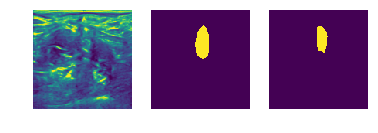

In [10]:
model.eval()

img, targets = test_data[99]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
binary_probs, binary = torch.max(outputs['binary'], 1)

#Comment/Uncomment to enable/disable binary classication
if binary.data.numpy() == 0:
    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

#### Are the binary probabilites making sense?
I found it was quite balanced if both values were around 50%. Therefore, train with classweights = [0.25, 0.75] for 5 epochs at least.

In [11]:
outputs['binary']

Variable containing:
 0.3736  0.6264
[torch.FloatTensor of size 1x2]

### Visualize many Images

Set num_example_imgs to whatever you want and modify the slice in test_data[from:to] accordingly.

#### ToDo:
1. Border overlay of mask over image.
2. Filter plots, weights dreaming.
3. ...


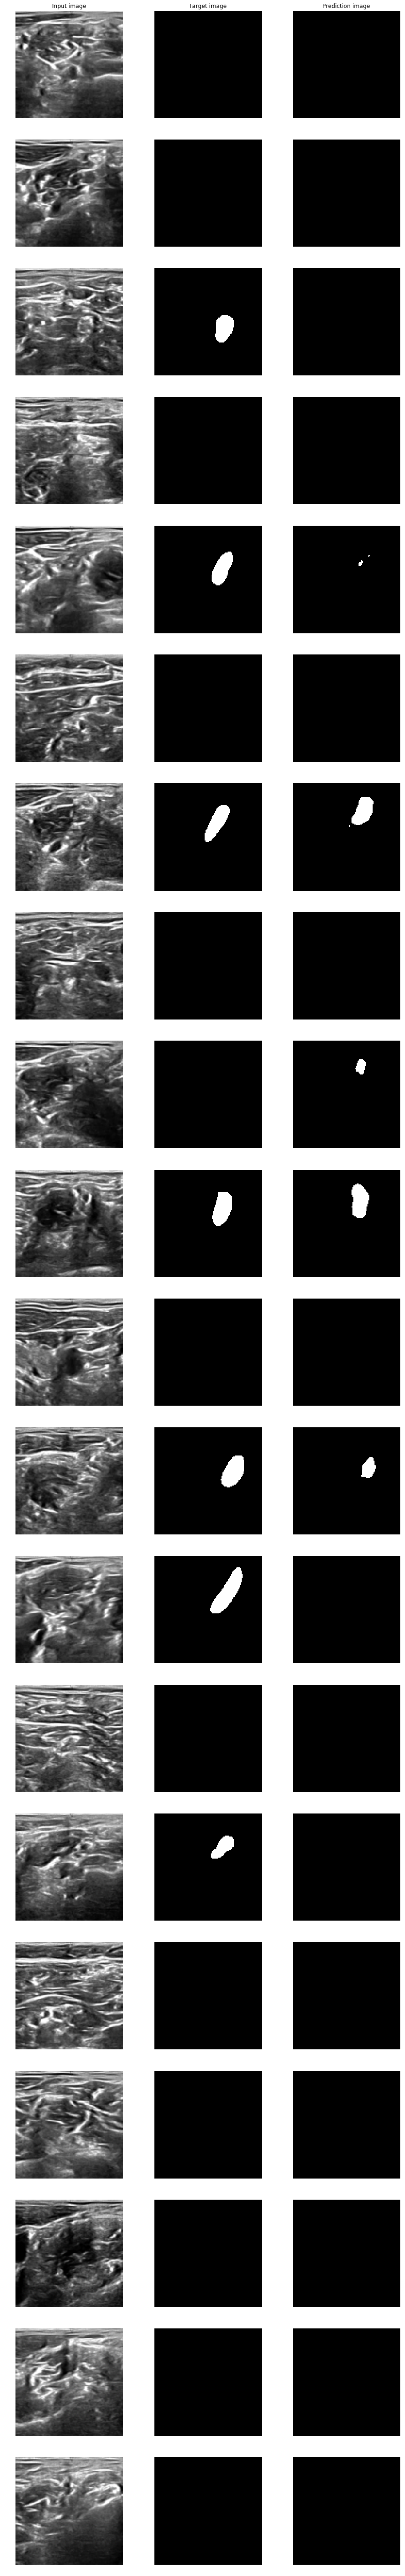

In [12]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[20:40]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
        
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

### Dice Coefficient on Testdata

In [10]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p*p) + np.sum(gt*gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    #Comment/Uncomment to compare with and without binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

0.87314721165390274

In [11]:
test_scores

[0.77989949748743714,
 1,
 1,
 1,
 1,
 0.87037037037037035,
 1,
 1,
 1,
 1,
 1,
 1,
 0.85688568856885694,
 1,
 1,
 0.87823439878234399,
 1,
 1,
 1,
 1,
 1,
 1,
 0.0,
 1,
 0.090090090090090086,
 1,
 0.53481012658227844,
 1,
 0.0,
 0.7053571428571429,
 1,
 0.52459016393442626,
 0.0,
 1,
 0.0,
 1,
 1,
 1,
 1,
 1,
 1,
 0.89991142604074403,
 0.79921259842519687,
 0.88239936858721391,
 0.80188679245283023,
 1,
 1,
 0.84587813620071683,
 1,
 1,
 0.77475516866158867,
 1,
 0.87330316742081449,
 1,
 1,
 1,
 1,
 0.76286072772898372,
 0.7917888563049853,
 1,
 1,
 1,
 0.60731948565776461,
 0.0,
 1,
 0.0,
 1,
 0.90146341463414636,
 1,
 1,
 1,
 1,
 1,
 1,
 0.0,
 1,
 1,
 1,
 0.88804265041888808,
 1,
 1,
 0.0,
 1,
 1,
 1,
 1,
 1,
 1,
 0.0,
 1,
 1,
 1,
 0.95169430425378509,
 1,
 0.0,
 0.83333333333333337,
 0.9247009148486981,
 1,
 0.56304985337243407,
 0.75631951466127401,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8296795952782462,
 0.82991985752448794,
 1,
 0.73140749846342967,
 1,
 1,
 1,
 0.7677329624478442

#### Highscore: score and indice of the best predicted image (with nerve).

In [ ]:
x = np.array(test_scores)
x[x==1] = 0
np.max(x), np.argmax(x)

#### Other Stuff
Calculation of ratios in datasets (interesting for balancing class weights)

In [ ]:
#Total ratio of pixels without/with nerve in dataset
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()
1 - mask/N, mask/N

In [ ]:
#Total ratio of images without/with nerve in dataset
mask = 0
for _, (img, target) in enumerate(test_data):
    mask += target['main'].sum()>0
1 - mask/len(test_data), mask/len(test_data)

### Stats

In [48]:
model.eval()
model.binary_out = True

sensitivity, specificity = [0, 0]
stats = {'true_positives': 0, 'false_positives': 0, 'true_negatives': 0, 'false_negatives': 0}

for i, (inputs, targets) in enumerate(test_loader):

    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    target = targets['main'].cpu().numpy()
    
    outputs = model(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    pred = pred.squeeze().data.cpu().numpy()
    
    ###!!! Comment in/ Comment out to include/exlude binary classification !!!###
    if binary.data.numpy() == 0:
        pred = pred * 0  
    
    target_present = 1 in target
    pred_present = 1 in pred
    
    if target_present and pred_present: #correctly predicted presence of a nerve
        stats['true_positives'] += 1 
    elif not target_present and pred_present: #wrongly predicted presence of a nerve
        stats['false_positives'] += 1
    elif not target_present and not pred_present: #correctly predicted absence of a nerve
        stats['true_negatives'] += 1
    elif target_present and not pred_present: #wrongly predicted absence of a nerve
        stats['false_negatives'] += 1
    
if((stats['true_positives'] + stats['false_negatives']) > 0):
    sensitivity = stats['true_positives'] / (stats['true_positives'] + stats['false_negatives'])
if((stats['true_negatives'] + stats['false_positives']) > 0):
    specificity = stats['true_negatives'] / (stats['true_negatives'] + stats['false_positives'])

print("Stats %s \n Sensitivity: %s \n Specificity: %s" % (stats, sensitivity, specificity)) 

true positive
true negative
true negative
false positive
true negative
true positive
false positive
false positive
false positive
false positive
false positive
false positive
true positive
false positive
true negative
true positive
false positive
false positive
false positive
true negative
false positive
false positive
true positive
false positive
true positive
false positive
true positive
true negative
false positive
true positive
true negative
true positive
true positive
false positive
true positive
false positive
false positive
true negative
false positive
false positive
true negative
true positive
true positive
true positive
true positive
false positive
false positive
true positive
true negative
true negative
true positive
false positive
true positive
true negative
false positive
false positive
false positive
true positive
true positive
true negative
false positive
false positive
true positive
true positive
false positive
false negative
false positive
true positive
false positive
f

In [49]:
np.save('stat_NervNet_maskonly.npy', stats)

In [3]:
np.load('stats/stat_NervNet_maskonly.npy').item()

{'false_negatives': 6,
 'false_positives': 175,
 'true_negatives': 129,
 'true_positives': 115}

In [12]:
%matplotlib gtk
plt.plot(1, 1)

ModuleNotFoundError: No module named 'matplotlib.backends.backend_gtkagg'